(0, Variable containing:
 1.0979
[torch.FloatTensor of size 1]
)
(43.80952380952381, 18.181818181818183, 13.043478260869565)
(5, Variable containing:
 0.3991
[torch.FloatTensor of size 1]
)
(39.04761904761905, 4.545454545454546, 17.391304347826086)
(10, Variable containing:
 1.0768
[torch.FloatTensor of size 1]
)
(41.904761904761905, 9.090909090909092, 13.043478260869565)
(15, Variable containing:
 1.2282
[torch.FloatTensor of size 1]
)
(40.0, 4.545454545454546, 13.043478260869565)
(20, Variable containing:
 1.1975
[torch.FloatTensor of size 1]
)
(44.76190476190476, 0.0, 0.0)
(25, Variable containing:
 0.9713
[torch.FloatTensor of size 1]
)
(46.666666666666664, 0.0, 0.0)
(30, Variable containing:
 1.1890
[torch.FloatTensor of size 1]
)
(44.76190476190476, 4.545454545454546, 4.3478260869565215)
(35, Variable containing:
 1.2440
[torch.FloatTensor of size 1]
)
(43.80952380952381, 0.0, 0.0)
(40, Variable containing:
 1.2365
[torch.FloatTensor of size 1]
)
(41.904761904761905, 0.0, 0.0)
(4

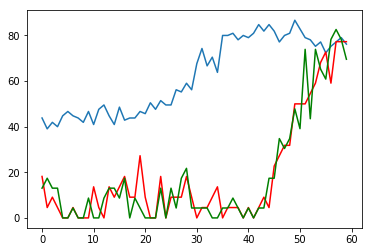

In [1]:
import numpy as np

def reformat(labels, num_labels):
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return np.array(labels).astype(float)


def datadownload():
    from sklearn import datasets
    iris = datasets.load_iris()
    data = iris.data
    
    labels = iris.target
    #labels = reformat(labels,3)
    
    train, train_labels = data[:int(data.shape[0]*0.7)], labels[:int(data.shape[0]*0.7)]
    valid, valid_labels = data[int(data.shape[0]*0.7):int(data.shape[0]*0.85)], labels[int(data.shape[0]*0.7):int(data.shape[0]*0.85)]
    test, test_labels = data[int(data.shape[0]*0.85):], labels[int(data.shape[0]*0.85):]
    return np.array(train), np.array(train_labels), np.array(valid), np.array(valid_labels), np.array(test), np.array(test_labels)

train,train_labels,valid,valid_labels,test,test_labels = datadownload()

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/predictions.shape[0])

import torch
from torch.autograd import Variable
import numpy as np
import pickle
import torch.nn as nn
import torch.optim as optim



N, D_in, H1, H2, H3, D_out = None, 4, 10, 20, 10, 3

global training
training = True

class randomActivation(torch.nn.Module):

    def __init__(self, mean=0, std=1, min=0.1, max=0.9):
        super(randomActivation, self).__init__()

    def forward(self, x):
        #gauss = torch.exp((-(x - self.mean) ** 2)/(2* self.std ** 2))
        #return torch.clamp(gauss, min=self.min, max=self.max)
        global training
        if not training:
            #print("Not Training")
            return torch.nn.Tanh()(x)
        a = torch.rand([1])
        if (a < 0.20).numpy():
            #print("tanh")
            return torch.nn.Tanh()(x)
        elif (a < 0.40).numpy():
            return torch.nn.Softplus()(x)
        elif (a < 0.60).numpy():
            return torch.nn.Softshrink()(x)
        elif (a < 0.80).numpy():
            return torch.nn.ReLU()(x)
        else:
            return torch.nn.Softsign()(x)

train_x = Variable(torch.Tensor(train))
train_y = Variable(torch.Tensor(train_labels))

valid_x = Variable(torch.Tensor(valid))
valid_y = Variable(torch.Tensor(valid_labels))

test_x = Variable(torch.Tensor(test))
test_y = Variable(torch.Tensor(test_labels))

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    randomActivation(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(H1, H2),
    randomActivation(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(H2, D_out),
    torch.nn.LogSoftmax(),
)

multiLabelLoss = torch.nn.NLLLoss()
optimizer = optim.Adam(model.parameters())



learning_rate = 0.01
batch_size = 50
total_training_samples = 150

import copy
    
train_labels2 = copy.deepcopy(train_labels)
valid_labels2 = copy.deepcopy(valid_labels)
test_labels2 = copy.deepcopy(test_labels)

train_labels2 = reformat(train_labels2,3)
valid_labels2 = reformat(valid_labels2,3)
test_labels2 = reformat(test_labels2,3)

results = []

for t in range(300):
    i = 0
    while i < total_training_samples:
        batch = train[i : i + batch_size]
        batch_labels = train_labels[i : i + batch_size]
        x = Variable(torch.Tensor(batch))
        y = Variable(torch.Tensor(batch_labels), requires_grad = False).type(torch.LongTensor)
        i += batch_size
        y_pred = model(x)
        loss = multiLabelLoss(y_pred, y)
        #print(loss, end = '\r')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if not t%5:
        global training
        training = False
        print(t, loss)
        train_pred = model(train_x)
        tracc = accuracy(train_pred.data.numpy(), train_labels2)
        valid_pred = model(valid_x)
        vacc = accuracy(valid_pred.data.numpy(), valid_labels2)
        #print(valid_pred.data.numpy())
        #raise ValueError
        test_pred = model(test_x)
        tacc = accuracy(test_pred.data.numpy(), test_labels2)
        print(tracc, vacc, tacc)
        results.append((tracc, vacc, tacc))
        training = True
y_pred = model(x)
print(x, y_pred)
results = np.array(results)
import matplotlib.pyplot as plt
#pickle.dump(results, open("TorchSwitchingAct.pickle", "wb"))
plt.plot(results[:, 0])
plt.plot(results[:, 1], 'r')
plt.plot(results[:, 2], 'g')
plt.show()
